In [1]:
from Bio import SeqIO

import pandas as pd 
import re
import requests
import json
import time

import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import pycountry 
import pycountry_convert as pc
pp = pprint.PrettyPrinter()
import numpy as np
from tabulate import tabulate
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import math
from string import punctuation
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
stemmer=SnowballStemmer("english")

## 1. Format the data

In [ ]:
df = pd.read_csv('PATH\data\CoR-allauth_Genbank[OBIS_and_patents].csv')

In [3]:
#get one entry for each country authorship per publication
df2 = df.drop_duplicates(subset = ['pubmed_id','titles', 'affiliation_country_ed']).reset_index().fillna(0)
df2

,index,pubmed_id,titles,year_published,lens_scholarly_id,times_cited_sci,times_cited_pat,affiliation_country_ed,affiliation,affiliation_id,author_lastname,author_firstname,author_id,first_author,last_author,affiliation_country,edited_country
0,0,37083277,Mitochondrial Genome Evolution in Annelida - A...,2023,144-805-740-810-069,0.0,0.0,NO,"Natural History Museum, University of Oslo, P....",0.0,Struck,Torsten H,2.088449e+09,first_author,not last_author,0,manually edited
1,1,37083277,Mitochondrial Genome Evolution in Annelida - A...,2023,144-805-740-810-069,0.0,0.0,DE,FB05 Biology/Chemistry; University of Osnabrüc...,0.0,Hoesel,Christoph,4.366636e+09,not first_author,not last_author,0,manually edited
2,5,37075879,Rich but morphologically problematic: An integ...,2023,147-013-640-760-109,0.0,0.0,AU,"Queensland Museum, Biodiversity and Geoscience...",0.0,Cutmore,Scott C,4.366170e+09,not first_author,last_author,0,manually edited
3,8,37050123,The Lush Fucales Underwater Forests off the Ci...,2023,129-128-464-655-680,0.0,0.0,IT,"Department of Science and Technology, Universi...",0.0,Russo,Giovanni Fulvio,4.361670e+09,not first_author,last_author,0,manually edited
4,10,37050123,The Lush Fucales Underwater Forests off the Ci...,2023,129-128-464-655-680,0.0,0.0,PT,"Centro de Ciências do Mar do Algarve (CCMAR), ...",0.0,Neiva,João,4.361670e+09,not first_author,not last_author,0,manually edited
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35461,128681,450133,Sequence divergence of rainbow trout protamine...,1979,023-441-386-274-635,27.0,0.0,GB,"Imperial Cancer Research Fund, London, UK",0.0,Jenkins,John R.,2.614789e+09,first_author,last_author,0,manually edited
35462,128682,386274,Nucleotide sequence of starfish initiator tRNA,1979,146-493-562-861-391,51.0,0.0,GB,Laboratory of Molecular Biology,170203145.0,Sugisaki,Hiroyuki,2.894239e+09,not first_author,not last_author,GB,manually edited
35463,128683,386274,Nucleotide sequence of starfish initiator tRNA,1979,146-493-562-861-391,51.0,0.0,0,0,0.0,Nishimura,Susumu,2.275095e+09,not first_author,last_author,0,unedited
35464,128686,115850,Nucleotide sequence of 5S ribosomal RNA from r...,1979,005-763-438-118-511,57.0,0.0,JP,Nagoya University,60134161.0,Takemura,Shosuke,2.582299e+09,not first_author,last_author,JP,manually edited


In [ ]:
# create words column and transform into words dataframe

title_words = []
pubmed_ids = []

mystopwords = stopwords.words("english")
n = 1
for title in list(df2['titles']):
    for word in title.split():
        if word.lower() not in mystopwords:
            title_words.append(stemmer.stem("".join([l for l in word if l not in punctuation]).lower()))       
            pubmed_ids.append(list((df2['pubmed_id'][df2['titles'] == title]))[0])
            
    n = n+1
    #if n == 5000:
    #    break

In [ ]:
d = {'words':title_words, 'pubmed_id':pubmed_ids}
df_words_all = pd.merge(pd.DataFrame(d), df2, how = 'left', on = 'pubmed_id') 

In [ ]:
len(list(set(df_words_all['words'])))

In [68]:
# remove lower extremes
to_del = []
nr = 0
for word in list(set(df_words_all['words'])):
    nr = nr +1
    print(nr)
    if len(list(set(df_words_all['pubmed_id'][df_words_all['words'] == word]))) < 5 or len(list(set(df_words_all['pubmed_id'][df_words_all['words'] == word]))) > 2500:
        to_del.append(word)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [ ]:
df_words = df_words_all[~df_words_all['words'].isin(to_del)]

In [118]:
df_words.to_csv('PATH\data\words.csv')

In [ ]:
# calculate citation per word (sum every pub, but don't count per country)

In [10]:
df_words = pd.read_csv('PATH\data\words.csv')

In [6]:
df_stats = df_words[['words','times_cited_pat', 'times_cited_sci', 'pubmed_id']].drop_duplicates()

In [8]:
df_patent_cit = df_stats.groupby('words')['times_cited_pat'].sum().reset_index(name = 'citations by patents').sort_values(['citations by patents'], ascending = False)

In [23]:
df_papers = df_stats.groupby('words')['pubmed_id'].count().reset_index(name='occurs in x papers').sort_values(['occurs in x papers'], ascending = False)
df_patent_cit_papers = pd.merge(df_patent_cit, df_papers, how = 'left', on = 'words')

In [24]:
df_patent_cit_med = df_stats.groupby('words')['times_cited_pat'].median().reset_index(name='Med citations by pat')
df_patent_cit_med_papers = pd.merge(df_patent_cit_papers, df_patent_cit_med, how = 'left', on = 'words')

In [25]:
df_patent_cit_av = df_stats.groupby('words')['times_cited_pat'].mean().reset_index(name='Av citations by pat')
df_patent_cit_med_mean_papers = pd.merge(df_patent_cit_med_papers, df_patent_cit_av, how = 'left', on = 'words')

In [26]:
df_science_cit_av = df_stats.groupby('words')['times_cited_sci'].mean().reset_index(name='Av citations by sci')
df_science_cit_mean = df_stats.groupby('words')['times_cited_sci'].median().reset_index(name='Median citations by sci')
df_science_cit = df_stats.groupby('words')['times_cited_sci'].sum().reset_index(name = 'citations by science').sort_values(['citations by science'], ascending = False)
df_patent_science_cit_med_mean_papers = pd.merge(df_patent_cit_med_mean_papers, df_science_cit_av, how = 'left', on = 'words').merge(df_science_cit_mean, how = 'left', on = 'words').merge(df_science_cit, how = 'left', on = 'words')

In [27]:
pat_tops = df_patent_science_cit_med_mean_papers['Av citations by pat'].quantile(0.995)
sci_tops = df_patent_science_cit_med_mean_papers['Av citations by sci'].quantile(0.995)

In [28]:
pat_tops

16.58817391304349

In [29]:
sci_tops

244.31294117647064

In [30]:
# cut highly cited ones and the most frequent one (would be more logical to integrate the latter step smwhere above)
# first take away the outliers, so that the indicator has more variance

df_patent_science_cit_med_mean_papers_notops = df_patent_science_cit_med_mean_papers[(df_patent_science_cit_med_mean_papers['Av citations by sci'] <= sci_tops)&(df_patent_science_cit_med_mean_papers['Av citations by pat'] <= pat_tops) & (df_patent_science_cit_med_mean_papers['occurs in x papers'] <= 2500)]

In [31]:
df_patent_science_cit_med_mean_papers_notops

,words,citations by patents,occurs in x papers,Med citations by pat,Av citations by pat,Av citations by sci,Median citations by sci,citations by science
2,protein,2937.0,1645,0.0,1.785410,54.318541,31.0,89354.0
5,clone,2500.0,1996,0.0,1.252505,41.457415,29.0,82749.0
6,cdna,2296.0,626,0.0,3.667732,48.148562,31.0,30141.0
7,analysi,2216.0,2007,0.0,1.104136,52.969606,30.0,106310.0
8,human,1961.0,143,0.0,13.713287,127.580420,32.0,18244.0
...,...,...,...,...,...,...,...,...
5204,anguilliform,0.0,17,0.0,0.000000,16.764706,5.0,285.0
5205,methionin,0.0,8,0.0,0.000000,29.250000,33.0,234.0
5206,anguibactin,0.0,5,0.0,0.000000,41.800000,43.0,209.0
5207,methylophaga,0.0,9,0.0,0.000000,55.222222,43.0,497.0


In [32]:
adjust = sci_tops/pat_tops
adjust

14.728139604586874

In [33]:
#create orientation indicator
df_patent_science_cit_med_mean_papers_orientation = df_patent_science_cit_med_mean_papers_notops.copy() 
df_patent_science_cit_med_mean_papers_orientation['Adjusted av citations by sci'] = df_patent_science_cit_med_mean_papers_orientation['Av citations by sci']/adjust

In [34]:
orientation = []
orientation_hsl = []
range_value = df_patent_science_cit_med_mean_papers_orientation['Adjusted av citations by sci'].max()+df_patent_science_cit_med_mean_papers_orientation['Av citations by pat'].max()
for word in list(df_patent_science_cit_med_mean_papers_orientation['words']):
    a = -list(df_patent_science_cit_med_mean_papers_orientation['Adjusted av citations by sci'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]+list(df_patent_science_cit_med_mean_papers_orientation['Av citations by pat'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]
    b = (a+df_patent_science_cit_med_mean_papers_orientation['Adjusted av citations by sci'].max())/range_value
    c = b*2-1
    orientation.append(c)
    orientation_hsl.append(b*360)

df_patent_science_cit_med_mean_papers_orientation['orientation'] = orientation
df_patent_science_cit_med_mean_papers_orientation['orientation_hsl'] = orientation_hsl

In [35]:
weighted_scis = []
weighted_pats = []
for word in list(df_patent_science_cit_med_mean_papers_orientation['words']):
    word_occurance_weight = math.sqrt(list(df_patent_science_cit_med_mean_papers_orientation['occurs in x papers'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0])
    weighted_sci = list(df_patent_science_cit_med_mean_papers_orientation['Av citations by sci'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]*word_occurance_weight
    weighted_scis.append(weighted_sci)
    weighted_pat = list(df_patent_science_cit_med_mean_papers_orientation['Av citations by pat'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]*word_occurance_weight
    weighted_pats.append(weighted_pat)
    
df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by sci'] = weighted_scis
df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by pat'] = weighted_pats

In [36]:
#create orientation indicator
adjust_weighted = df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by sci'].max()/df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by pat'].max() 
df_patent_science_cit_med_mean_papers_orientation['Adjusted weighted av citations by sci'] = df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by sci']/adjust_weighted

In [37]:
orientation_weighted = []
orientation_hsl_weighted = []
range_value_weighted = df_patent_science_cit_med_mean_papers_orientation['Adjusted weighted av citations by sci'].max()+df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by pat'].max()


for word in list(df_patent_science_cit_med_mean_papers_orientation['words']):
    a = -list(df_patent_science_cit_med_mean_papers_orientation['Adjusted weighted av citations by sci'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]+list(df_patent_science_cit_med_mean_papers_orientation['Weighted av citations by pat'][df_patent_science_cit_med_mean_papers_orientation['words'] == word])[0]
    b = (a+df_patent_science_cit_med_mean_papers_orientation['Adjusted weighted av citations by sci'].max())/range_value_weighted
    c = b*2-1
    orientation_weighted.append(c)
    orientation_hsl_weighted.append(b*360)

df_patent_science_cit_med_mean_papers_orientation['orientation_weighted'] = orientation_weighted
df_patent_science_cit_med_mean_papers_orientation['orientation_hsl_weighted'] = orientation_hsl_weighted

In [40]:
# I think I don't need df_words_stats at all, just take the previous one
df_words_stats = df_patent_science_cit_med_mean_papers_orientation.dropna()
df_words_stats['frequency_log'] = [math.log(x) for x in list(df_words_stats['occurs in x papers'])]

In [ ]:
df_words_stats.to_csv('PATH\data\words_semantic_analysis.csv')

## 2. Visualize

In [2]:
df_words_stats = pd.read_csv('PATH\data\words_semantic_analysis.csv')

In [3]:
df_words_stats['node_viz_weighted'] = [math.exp(abs(x))**10 for x in df_words_stats['orientation_weighted']]
df_words_stats['node_viz'] = [math.exp(abs(x))**10 for x in df_words_stats['orientation']]

In [31]:
df_words_stats.sort_values(['orientation_weighted'], ascending = False)

,Unnamed: 0,words,citations by patents,occurs in x papers,Med citations by pat,Av citations by pat,Av citations by sci,Median citations by sci,citations by science,Adjusted av citations by sci,orientation,orientation_hsl,Weighted av citations by sci,Weighted av citations by pat,Adjusted weighted av citations by sci,orientation_weighted,orientation_hsl_weighted,frequency_log,node_viz_weighted,node_viz
4,8,human,1961.0,143,0.0,13.713287,127.580420,32.0,18244.0,8.662358,0.313636,236.454450,1525.639923,163.987058,81.155222,0.505112,270.920166,4.962845,156.197358,23.019883
18,23,fluoresc,1035.0,68,1.0,15.220588,121.102941,31.5,8235.0,8.222555,0.432393,257.830716,998.640436,125.512186,53.121897,0.441439,259.459027,4.219508,82.631453,75.484600
23,30,generat,933.0,83,0.0,11.240964,79.397590,37.0,6590.0,5.390877,0.362378,245.227999,723.346473,102.410055,38.477850,0.389861,250.175031,4.418841,49.333967,37.478886
54,63,desaturas,494.0,32,0.0,15.437500,79.406250,60.0,2541.0,5.391465,0.618295,291.293175,449.189583,87.327687,23.894288,0.386820,249.627518,3.465736,47.855949,484.420894
22,29,fatti,937.0,98,0.0,9.561224,64.479592,40.0,6319.0,4.377986,0.321706,237.907010,638.315393,94.651293,33.954688,0.370130,246.623483,4.584967,40.500107,24.954549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,225,phylogeni,169.0,815,0.0,0.207362,75.080982,48.0,61191.0,5.097791,-0.292704,127.313351,2143.427243,5.919812,114.017935,-0.659187,61.346355,6.703188,729.142486,18.672205
60,69,communiti,442.0,629,0.0,0.702703,97.117647,58.0,61087.0,6.594020,-0.353749,116.325112,2435.698197,17.623694,129.565060,-0.682623,57.127829,6.444131,921.710985,34.380645
11,15,marin,1346.0,1441,0.0,0.934074,74.354615,43.0,107145.0,5.048473,-0.245372,135.832987,2822.538788,35.457905,150.142742,-0.699353,54.116464,7.273093,1089.560608,11.631570
5,9,genom,1835.0,2007,0.0,0.914300,68.813154,20.0,138108.0,4.672223,-0.223630,139.746559,3082.798577,40.960230,163.987058,-0.750223,44.959898,7.604396,1812.075072,9.358662


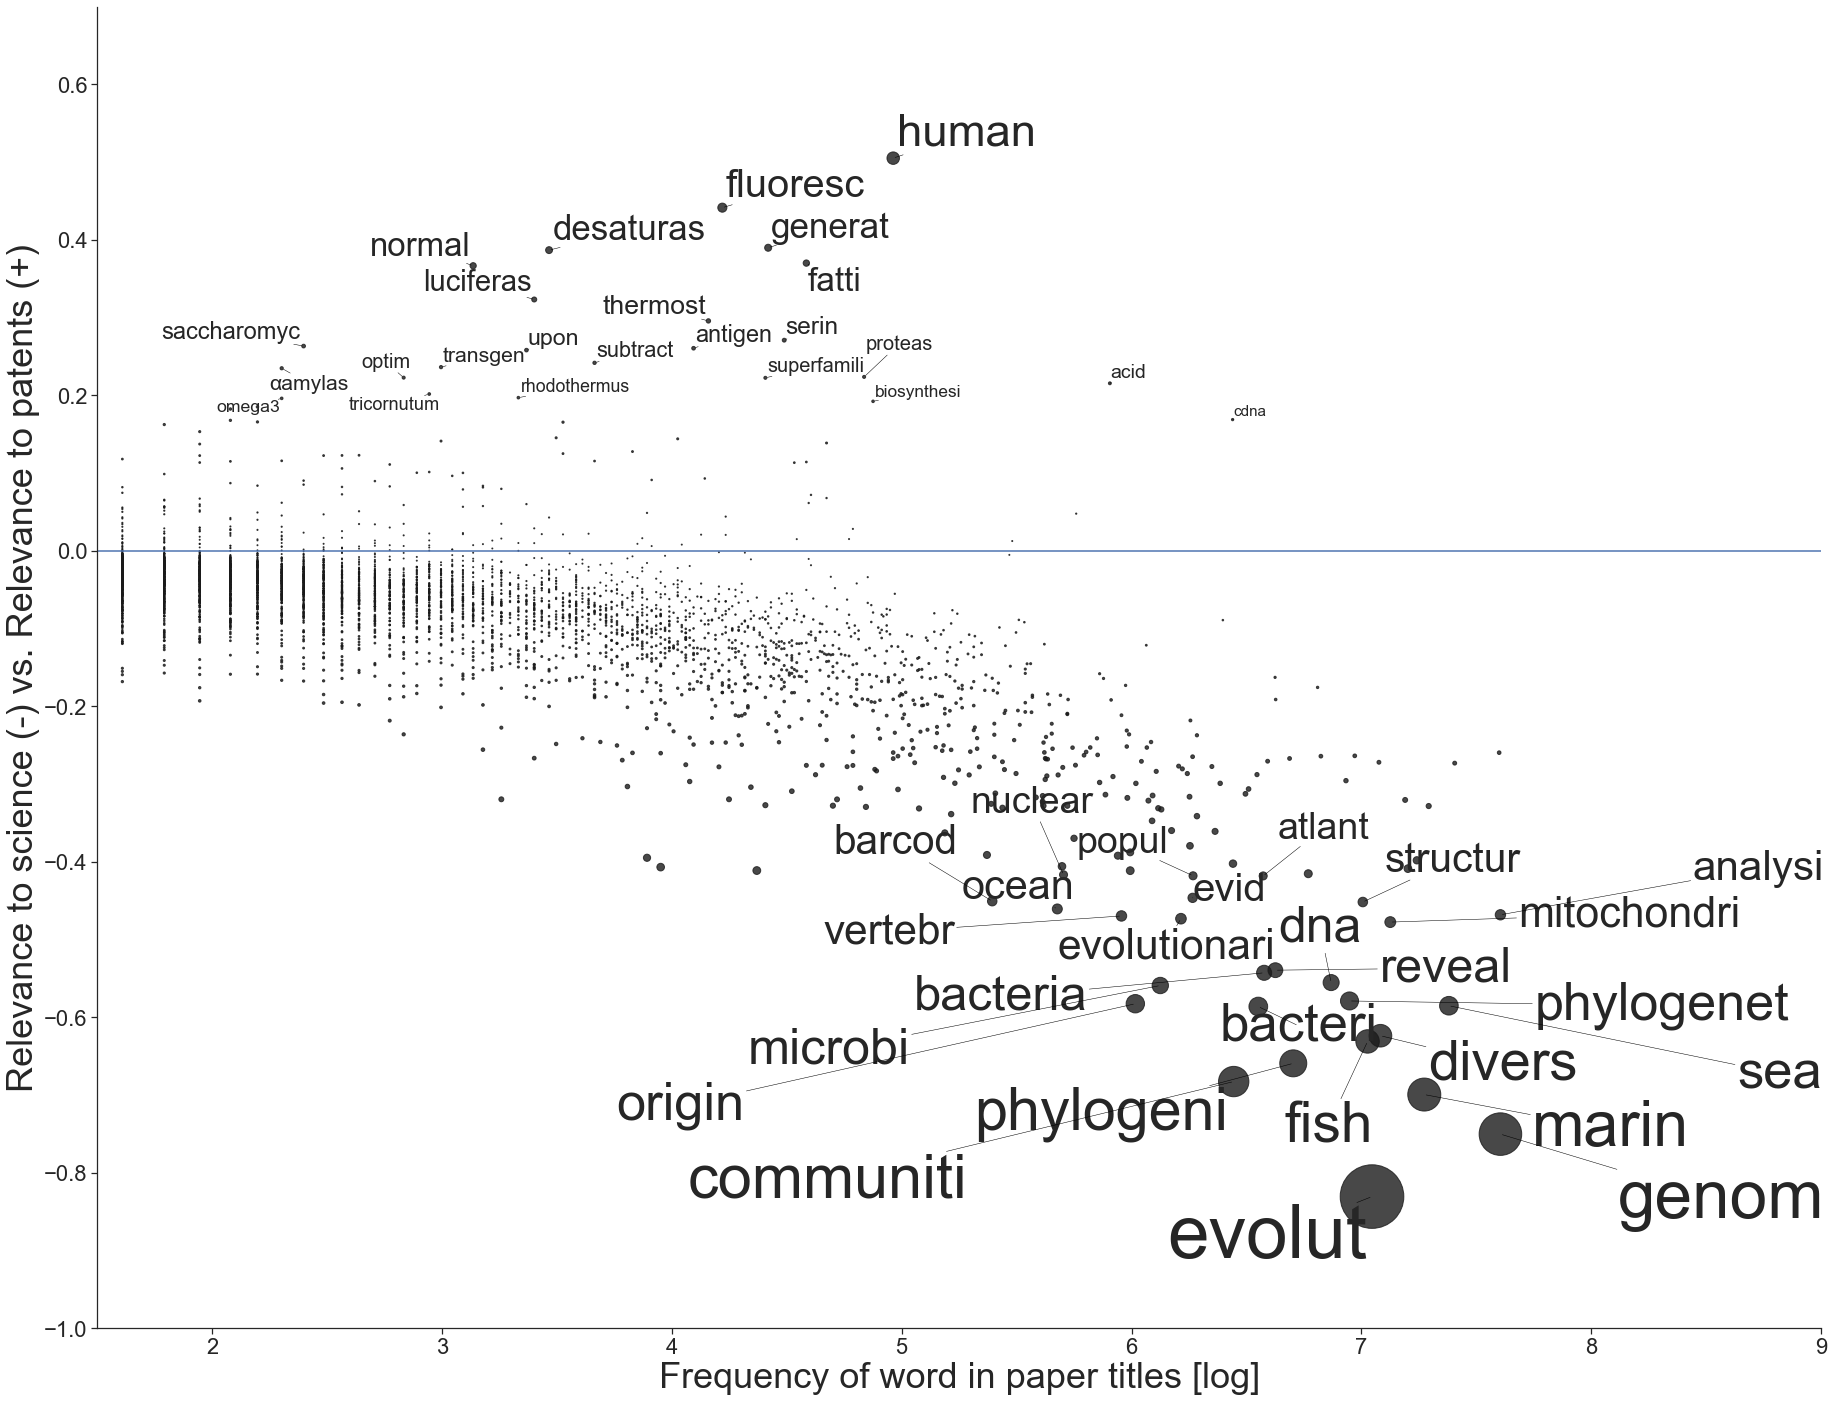

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Your existing code for creating the scatter plot
sns.set_style('white')
sns.set_style('ticks')
size = 20
g = sns.lmplot(x='frequency_log', y='orientation_weighted', data=df_words_stats[(df_words_stats['occurs in x papers'] <= 5000) & (df_words_stats['occurs in x papers'] >= 5)], height=size, aspect=size*1.3/size, markers='o', fit_reg=False, scatter_kws={"s": df_words_stats['node_viz_weighted'], "color": "k"}).set(xlim=(1.5,9), ylim=(-1,0.7))
plt.axhline(y=0) 
# Filter the DataFrame to get the data points to label
word_labelling = df_words_stats[(df_words_stats['occurs in x papers'] >= 10) & (df_words_stats['orientation_weighted'] >= df_words_stats['orientation_weighted'].quantile(0.995)) | (df_words_stats['occurs in x papers'] >= 10) & (df_words_stats['orientation_weighted'] <= df_words_stats['orientation_weighted'].quantile(0.005))].drop_duplicates().reset_index()

# Loop through the filtered data points and annotate each point with an arrow
annotations = []
for i, row in word_labelling.iterrows():
    annotation = plt.annotate(
        row['words'],
        xy=(row['frequency_log'], row['orientation_weighted']),
        xytext=(row['frequency_log'], row['orientation_weighted']),
        fontsize=size* abs(word_labelling['orientation_weighted'][i]) * 4.5,
        ha='center',
        va='center'  # Position the annotation at the center of the node
    )
    annotations.append(annotation)

# Use adjust_text to automatically adjust the positions of the labels
adjust_text(annotations, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Your existing code for formatting the plot and adding labels

# Finally, show the plot
plt.xlabel('Frequency of word in paper titles [log]', fontsize=size*1.8)
plt.ylabel('Relevance to science (-) vs. Relevance to patents (+)', fontsize=size*1.8)
#plt.title('Word orientation (weighted)', fontsize=size*2.5)
sns.set(font_scale=2)
plt.tight_layout()
#plt.show()


plt.savefig('PATH\plots\word_leanings_weighted_new_pub.svg', format="svg")
plt.savefig('PATH\plots\word_leanings_weighted_new_pub.jpg', format="jpg")

In [11]:
# analyse words separately 
df_select = pd.merge(df_words[['words', 'titles', 'pubmed_id','affiliation_country_ed', 'affiliation','times_cited_sci', 'times_cited_pat']], df_words_stats[['words','Av citations by sci', 'Median citations by sci', 'Av citations by pat','Med citations by pat','occurs in x papers','orientation','orientation_weighted']], how = 'left', on = 'words').dropna()
df_select['times_cited_sci_log'] = np.log(df_select['times_cited_sci'].replace({0:np.nan}))
df_select['times_cited_pat_log'] = np.log(df_select['times_cited_pat'].replace({0:np.nan}))

In [32]:
selected_words = ['genom','human','evolut','fluoresc','marin','generat','communiti','desaturas']

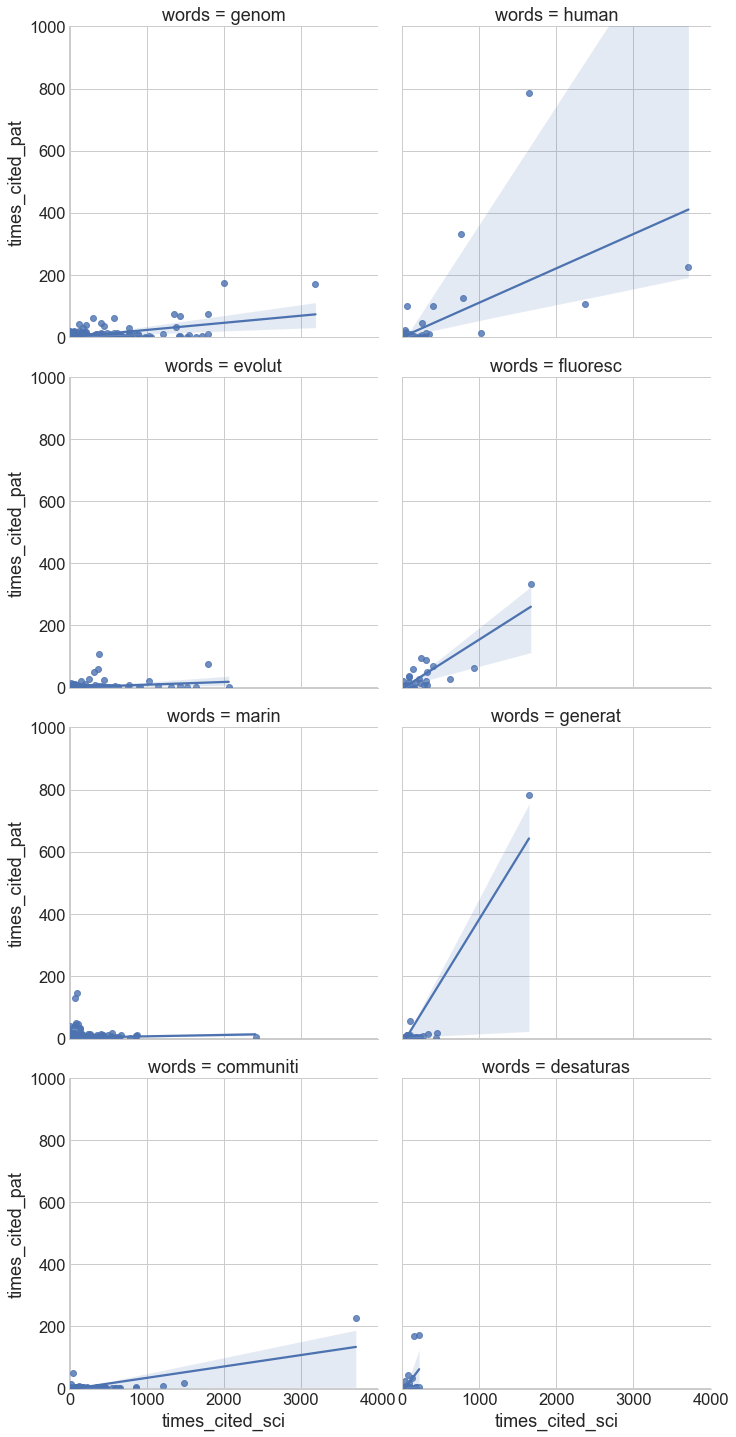

In [37]:
plt.style.use('seaborn-whitegrid')  # You can change 'seaborn-whitegrid' to any available style you like

# Your original code
sns.lmplot(data=df_select[df_select['words'].isin(selected_words)].drop_duplicates(subset=['words', 'pubmed_id']),
           x="times_cited_sci", y='times_cited_pat',
           height=size*2, aspect=size/size,
           col="words", col_wrap=2,
           col_order=selected_words).set(xlim=(-2,4000), ylim=(-2, 1000))

# Show the plot

plt.savefig('PATH\plots\word_analysis.svg', format="svg")
plt.savefig('PATH\plots\word_analysis.jpg', format="jpg")

In [39]:
df_select[df_select['words'] == 'genom'].drop_duplicates(subset=['words','pubmed_id','affiliation_country_ed'])

,words,titles,pubmed_id,affiliation_country_ed,affiliation,times_cited_sci,times_cited_pat,Av citations by sci,Median citations by sci,Av citations by pat,Med citations by pat,occurs in x papers,orientation,orientation_weighted,times_cited_sci_log,times_cited_pat_log
2,genom,Mitochondrial Genome Evolution in Annelida - A...,37083277,NO,"Natural History Museum, University of Oslo, P....",0.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,NaN,NaN
3,genom,Mitochondrial Genome Evolution in Annelida - A...,37083277,DE,FB05 Biology/Chemistry; University of Osnabrüc...,0.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,NaN,NaN
897,genom,The Complete Mitochondrial Genome of Homophyll...,36980967,CN,"Third Institute of Oceanography, Ministry of N...",0.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,NaN,NaN
1353,genom,Genome assembly of the deep-sea coral Lophelia...,36935863,US,"Department of Biological Sciences, Lehigh Univ...",0.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,NaN,NaN
1365,genom,Characterization of the complete mitochondrial...,36926642,ZA,"Department of Genetics, Molecular Breeding and...",0.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682442,genom,Distribution of the salmonid Hpa 1 family in t...,1707099,JP,University of Tsukuba,13.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,2.564949,NaN
683277,genom,Characterisation of a chloroplast-encoded sec ...,1618309,AU,Macquarie University,30.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,3.401197,NaN
684903,genom,A novel mitochondrial genome organization for ...,1386586,US,Iowa State University,294.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,5.683580,NaN
685253,genom,psaE and trnS(CGA) are encoded on the plastid ...,1373082,CA,Halifax,15.0,0.0,68.813154,20.0,0.9143,0.0,2007.0,-0.22363,-0.750223,2.708050,NaN


## 3. Create dataset

In [24]:
df_export = df_words_stats[['words', 'occurs in x papers', 'frequency_log','Av citations by sci', 'Adjusted weighted av citations by sci', 'Av citations by pat', 'Weighted av citations by pat', 'orientation', 'orientation_weighted']].rename(columns = {'frequency_log':'occurs in x papers_log'})

In [25]:
patenting_words = df_export[df_export['orientation_weighted'] > 0]
science_words = df_export[df_export['orientation_weighted'] < 0]

In [26]:
top_quantile_pat = patenting_words[patenting_words['orientation_weighted'] >= patenting_words['orientation_weighted'].quantile(0.7)]
bottom_quantile_sci = science_words[science_words['orientation_weighted'] <= science_words['orientation_weighted'].quantile(0.3)]

In [27]:
relevance = []
for word in list(df_export['words']): 
    relevant = ''
    if word in list(patenting_words['words']):
        relevant = 'neutral'
        if word in list(top_quantile_pat['words']):
            relevant = 'patent_relevant'
        relevance.append(relevant)
        pass
    elif word in list(science_words['words']): 
        relevant = 'neutral'
        if word in list(bottom_quantile_sci['words']):
            relevant = 'science_relevant'
        relevance.append(relevant)
        pass
    else: 
        print('word'+ 'unlabeled word!')
        
    
    
        

In [28]:
df_export['relevance'] = relevance

In [29]:
df_export.to_csv('PATH\data\words_suppl_noG77.csv', index = False) #complete the suppl material in the G77 notebook